In [1]:
 # Import some standard/utility libraries:
import os, sys, six # six provides python 2/3 compatibility

# Import our numerical/scientific libraries, scipy and numpy:
import numpy as np
import scipy as sp
import nibabel as nib
from os.path import join as pjoin
import h5py

import scipy.io as sio
# The neuropythy library is a swiss-army-knife for handling MRI data, especially
# anatomical/structural data such as that produced by FreeSurfer or the HCP.
# https://github.com/noahbenson/neuropythy
import neuropythy as ny

# Import graphics libraries:
# Matplotlib/Pyplot is our 2D graphing library:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [17]:
sub = ny.freesurfer_subject('/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/bold/derivatives/freesurfer/fsaverage')
reg_fsa = sub.lh.registrations['fsaverage']
reg_nat = sub.lh.registrations['native']
reg_fsa,reg_nat

(Mesh(<3D>, <327680 faces>, <163842 vertices>),
 Mesh(<3D>, <327680 faces>, <163842 vertices>))

In [3]:
# Here in the following procedure we get a method how to make projections 
fsaverage = ny.freesurfer_subject('/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/bold/derivatives/freesurfer/fsaverage')
# Next, let's find the location of V1. We can do this using the 'V1_weight'
# property, which gives the probability that each vertex on the cortical
# surface is in V1, based on anatomical alignment.
v1_centers = {}
for h in ['lh', 'rh']:
    # Get the Cortex object for this hemisphere.
    cortex = fsaverage.hemis[h]
    # We're dealing with the cortical sphere, so get that surface.
    sphere = cortex.registrations['native']
    # Grab the V1_weight property and the coordinates.
    v1_weight = sphere.prop('V1_weight')
    coords = sphere.coordinates
    # Now, we can take a weighted average of the coordinates in V1.
    v1_center = np.sum(coords * v1_weight[None,:], axis=1)
    v1_center /= np.sum(v1_weight)
    # Save this in the v1_centers dict.
    v1_centers[h] = v1_center

# See what got saved:
print(v1_centers)

v1_rights = {}
for h in ['lh', 'rh']:
    # Once again, we get the Cortex object for this hemisphere and the
    # spherical surface.
    cortex = fsaverage.hemis[h]
    # cortex = sub.hemis[h]
    sphere = cortex.registrations['native']
    # Now, we want the cortex_label property, which is True for points not
    # on the medial wall and False for points on the medial wall.
    weight = sphere.prop('cortex_label')
    # We want to find the point at the middle of the medial wall, so we
    # want to invert this property (True values indicate the medial wall).
    weight = ~weight
    # Now we take the weighted average again (however, since these weight
    # values are all True or False (1 or 0), we can just average the
    # points that are included.
    coords = sphere.coordinates
    mwall_center = np.mean(coords[:, weight], axis=1)
    # If this is the RH, we invert this coordinate
    v1_rights[h] = -mwall_center if h == 'rh' else mwall_center

# See what got saved.
print(v1_rights)

method ='equirectangular' #'equirectangular'#'orthographic' # or: , sinusoidal, mercator
radius = np.pi/3

# Now, we make the projections:
map_projs = {}
for h in ['lh', 'rh']: 
    # Note that the last parameter here is the registration; by setting this
    # to 'fsaverage' means that when this map projection is used to make a
    # flatmap of a subject's cortex, it will use their fsaverage-aligned
    # registration for the projection. This causes the maps of subjects to
    # appear roughly similar despite differences in anatomical structure.
    mp = ny.map_projection(chirality=h,
                           center=v1_centers[h],
                           center_right=v1_rights[h],
                           method=method,
                           radius=radius,
                           registration='fsaverage')
    map_projs[h] = mp

# See what this created.
map_projs

{'lh': array([ 37.79666838, -70.80057563, -54.63788443]), 'rh': array([-60.23899003, -55.23617797, -52.21611106])}
{'lh': array([ 61.1048203 ,  27.73087493, -58.39053144]), 'rh': array([ 65.44048432, -42.47869361,  42.30694955])}


{'lh': MapProjection(<LH>, <fsaverage>),
 'rh': MapProjection(<RH>, <fsaverage>)}

In [4]:
fspath = '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/bold/derivatives/freesurfer'
sub = ny.freesurfer_subject(pjoin(fspath, 'sub-02'))
reg_fsa = sub.lh.registrations['fsaverage']
reg_nat = sub.lh.registrations['native']
reg_fsa,reg_nat

(Mesh(<3D>, <294756 faces>, <147380 vertices>),
 Mesh(<3D>, <294756 faces>, <147380 vertices>))

In [61]:
reg_fsa.labels, reg_nat.labels, np.allclose(reg_fsa.labels, reg_nat.labels)

(array([     0,      1,      2, ..., 147377, 147378, 147379]),
 array([     0,      1,      2, ..., 147377, 147378, 147379]),
 True)

In [5]:
print(sub)
flatmaps = {h: mp(sub.hemis[h]) for (h,mp) in map_projs.items()}
print(flatmaps)

Subject(<sub-02>, <'/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/bold/derivatives/freesurfer/sub-02'>)
{'lh': Mesh(<2D>, <76809 faces>, <38676 vertices>), 'rh': Mesh(<2D>, <80552 faces>, <40560 vertices>)}


(-36.63589493098161, 36.652453280623924, -36.63701189418493, 36.65226810095433)

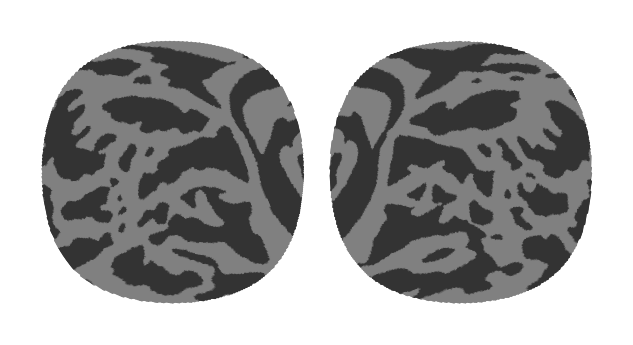

In [20]:
# We'll make two axes, one for each hemisphere.
(fig, (left_ax, right_ax)) = plt.subplots(1,2, figsize=(2,1), dpi=72*4)
# Make sure there isn't a bunch of extra space around them.
fig.subplots_adjust(0,0,1,1,0,0)

ny.cortex_plot(flatmaps['lh'], axes=left_ax)#underlay=avg_curvunderlay=lh_underlay_quota
ny.cortex_plot(flatmaps['rh'], axes=right_ax)

left_ax.axis('off')
right_ax.axis('off')

In [57]:
flatmaps['lh'].labels

array([     0,      1,      2, ..., 147111, 147112, 147113])

In [6]:
## 生成指标
transfer_file = '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodanalysis/prfresults.mat'
ciftifsaverageix = h5py.File(transfer_file,'r')['ciftifsaverageix'][:]
ciftifsaveragebad = h5py.File(transfer_file,'r')['ciftifsaveragebad'][:]
transferix = np.squeeze(ciftifsaverageix.astype(np.int64)) - 1
bad_id = np.squeeze(ciftifsaveragebad.astype(np.int64))

In [16]:
ppath = '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/anal/brainmap/fullmodelperformance'
spath = '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/anal/brainmap/featuresigmap'
performance = nib.load(pjoin(ppath, 'sub-all_ly-googlenet-conv2_full-model-r-train.dscalar.nii')).get_fdata()
sigmap = nib.load(pjoin(spath, 'sub-02_ly-googlenet-conv2_featureSig.dlabel.nii')).get_fdata()

fs_performance = performance[:, transferix]
fs_sigmap = sigmap[:, transferix]
fs_performance[:, bad_id], fs_sigmap[:, bad_id] = np.nan, np.nan

lh_mesh3D_fs_quota = fs_sigmap[:, 0:163842]
lh_flatmap_quota = lh_mesh3D_fs_quota[:, flatmaps['lh'].labels]

rh_mesh3D_fs_quota = fs_sigmap[:, 163842::]
rh_flatmap_quota = rh_mesh3D_fs_quota[:, flatmaps['rh'].labels]


lh_mesh3D_underlay_quota = fs_performance[1, :][0:163842]
lh_underlay_quota = lh_mesh3D_underlay_quota[flatmaps['lh'].labels]

rh_mesh3D_underlay_quota = fs_performance[1, :][163842::]
rh_underlay_quota = rh_mesh3D_underlay_quota[flatmaps['rh'].labels]

lh_flatmap_quota.shape, lh_underlay_quota.shape

((63, 38676), (38676,))

(-36.657857899130846,
 36.622095989395945,
 -36.61810339398872,
 36.61551228575019)

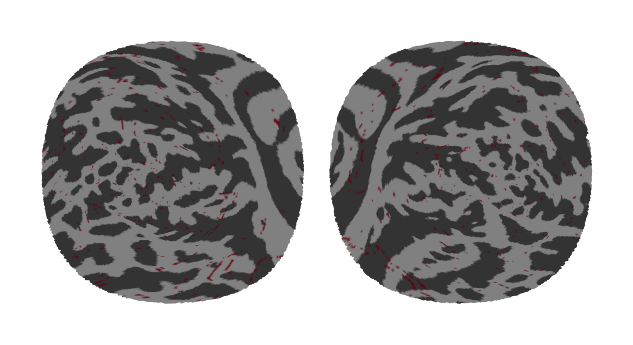

In [25]:
# We'll make two axes, one for each hemisphere.
(fig, (left_ax, right_ax)) = plt.subplots(1,2, figsize=(2,1), dpi=72*4)
# Make sure there isn't a bunch of extra space around them.
fig.subplots_adjust(0,0,1,1,0,0)

# We provide the cortex_plot function with a property name that it should
# use for the color; we also provide a colormap (cmap).
ny.cortex_plot(flatmaps['lh'], axes=left_ax,
               color=lh_flatmap_quota[1],
               cmap='Reds', mask=(lh_flatmap_quota[1]>0), alpha=0.9,)#underlay=lh_underlay_quota
ny.cortex_plot(flatmaps['rh'], axes=right_ax,
               color=rh_flatmap_quota[1],
               cmap='Reds', mask=(rh_flatmap_quota[1]>0), alpha=0.9,)#underlay=rh_underlay_quota

left_ax.axis('off')
right_ax.axis('off')